<a href="https://colab.research.google.com/github/anferivera/Programming/blob/main/4_interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpolation Methods

based in Diego Restrepo notebooks. https://github.com/restrepo/ComputationalMethods

Due to the discrete (and sometimes sparse) nature of experiments and observations, data taking procedures will always produce discrete data as well. Even, as we have seen before, information only can be discretely presented into a computer due to the binary representation. However, when we are dealing with physical models, continuous and smooth properties are of course preferred. Interpolation techniques allow then to recover a continuous field (intermediate values) from sparse datasets. Throughout this section we shall cover some of these interpolation methods.

- - -
- [Linear Interpolation](#Linear-Interpolation)
    - [Steps](#Steps-LI)
    - [Example 1](#Example-1)
- [Lagrange Polynomial](#Lagrange-Polynomial)
    - [Derivation](#Derivation)
    - [Steps](#Steps-LP)
    - [Activity](#Activity-LP)
- [Divided Differences](#Divided-Differences)
    - [Example 2](#Example-2)
- [Hermite Interpolation](#Hermite-Interpolation)
    - [Derivation in terms of divided differences](#Derivation-in-terms-of-divided-differences)
    - [Example 3](#Example-3)
- - -

In [ ]:
import numpy as np
%pylab inline
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.core.display import Image

Populating the interactive namespace from numpy and matplotlib


- - -

# Linear Interpolation

When we have a set of discrete points of the form $(x_i, y_i)$ for $1\leq i \leq N$, the most natural way to obtain (approximate) any intermediate value is assuming points connected by lines. Let's assume a set of points $(x_i, y_i)$ such that $y_i = f(x_i)$ for an unknown function $f(x)$, if we want to approximate the value $f(x)$ for $x_i\leq x \leq x_{i+1}$, we construct an equation of a line passing through $(x_i,y_i)$ and $(x_{i+1},y_{i+1})$, yielding:

$$\frac{y-y_i}{x-x_i} = \frac{y_{i+1}-y_i}{x_{i+1}-x_i} \ \ \longrightarrow  f(x)\approx y = \frac{y_{i+1}-y_i}{x_{i+1}-x_i}(x-x_i) + y_i $$

and this can be applied for any $x$ such that $x_0\leq x \leq x_N$ and where it has been assumed an ordered set $\left\{x_i\right\}_i$.

## Steps LI

Once defined the mathematical basis behind linear interpolation, we proceed to establish the algorithmic steps for an implementation.

1. Establish the dataset you want to interpolate, i.e. you must provide a set of the form $(x_i,y_i)$.
2. Give the value $x$ where you want to approximate the value $f(x)$.
3. Find the interval $[x_i, x_{i+1}]$ in which $x$ is embedded.
4. Use the above expression in order to find $y=f(x)$.

## Example 1

Sample the function $f(x) = \sin(x)$ between $0$ and $2\pi$ using $N=10$ intervals. Plot both, the interpolation and the original function.

In [ ]:
#Linear Interpolating Function
def LinearInterpolator( x, Xn, Yn ):

    #Sorting data, in case they are not
    Yn = Yn[np.argsort(Xn)]
    Xn = Xn[np.argsort(Xn)]

    #Detecting size of x
    try:
        Ninter = len(x)
    except:
        Ninter = 1
        x = np.array([x,])

    #Constructing function for each iteration
    term = lambda x, i: (Yn[i+1] - Yn[i])/(Xn[i+1] - Xn[i])*(x - Xn[i]) + Yn[i]

    #Detecting intervals for each x, [x_i, x_i+1] and interpolating
    y = []
    for n in range(Ninter):
        for i in range(len(Xn)):
            if x[n] <= Xn[i]:
                break
        y.append( term(x[n],i-1) )

    return np.array(y)

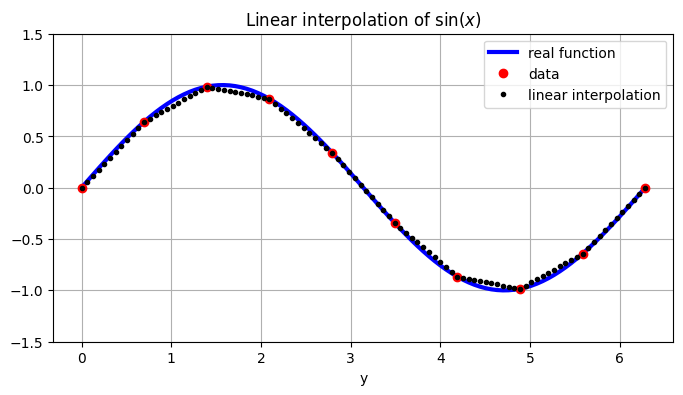

In [ ]:
#Function
def function(x):
    return np.sin(x)

#Number of intervals for data
Ndat = 10
Xn = np.linspace( 0, 2*np.pi, Ndat )
Yn = function(Xn)

#Obtaining linear interpolation
Ninter = 100
x = np.linspace( 0, 2*np.pi, Ninter )
y = LinearInterpolator( x, Xn, Yn )
f = function(x)

#Plotting
plt.figure( figsize=(8,4) )
plt.plot( x, f, color="blue", linewidth=3, label="real function" )
plt.plot( Xn, Yn, "o", color="red", label="data" )
#plt.plot( x, y, color="black", linewidth=2, label="linear interpolation" )
plt.plot( x, y, 'k.', label="linear interpolation" )

#Formatting
plt.legend()
plt.grid()
plt.xlabel( "x" )
plt.xlabel( "y" )
plt.ylim( (-1.5,1.5) )
plt.title( "Linear interpolation of $\sin(x)$" )
plt.show()

### <font color='red'>     **Activity: Linear Interpolation** </font>
    
1.  In an Jupyter-notebook, use the previous code and explore the behaviour of the Linear Interpolation algorithm when varying the number of data used.
2.  Construya la interpolación lineal para la función $f(x)=x^3$ en $x\, ϵ\, [-9,9]$


- - -

# Lagrange Polynomial

Algebraic polynomials are very special functions as they have properties like differentiability (unlike linear interpolation) and continuity that make them useful for approximations like interpolation. A Polynomial is defined as a function given by the general expression:

$$P_n(x) = a_nx^n + a_{n-1}x^{n-1} + \cdots + a_1 x + a_0$$

where $n$ is the polynomial degree.

Another important property of polynomials is given by the [Weierstrass Approximation Theorem](http://en.wikipedia.org/wiki/Stone%E2%80%93Weierstrass_theorem), which states given a cotinuous function $f$ defined on a interval $[a,b]$, for all $\epsilon >0$, there exits a polynomial $P(x)$ such that

$$|f(x) - P(x)|<\epsilon\ \ \ \ \  \mbox{for all }\ x\ \mbox{ in }\ [a,b].$$

This theorem guarantees the existence of such a polynomial, however it is necessary to propose a scheme to build it.

## Derivation

Let's suppose a well-behaved yet unknown function $f$ and two points $(x_0,y_0)$ and $(x_1,y_1)$ for which $f(x_0) = y_0$ and $f(x_1) = y_1$. With this information we can build a first-degree polynomial that passes through both points by using the last equation in sec. [Linear Interpolation](interpolation.ipynb#Linear-Interpolation), we have

$$P_1(x) = \left[ \frac{y_{1}-y_0}{x_{1}-x_0} \right]x + \left[ y_0 - \frac{y_{1}-y_0}{x_{1}-x_0}x_0 \right]$$

We can readily rewrite this expression like:

$$P_1(x) = L_0(x)f(x_0) + L_1(x)f(x_1)$$

where we define the functions $L_0(x)$ and $L_1(x)$ as:

$$L_0(x) = \frac{x-x_1}{x_0-x_1} \mbox{ and } L_1(x) = \frac{x-x_0}{x_1-x_0}$$

Note then that

$$L_0(x_0) = 1,\ \ \ L_0(x_1) = 0,\ \ \ L_1(x_0) = 0,\ \ \ L_1(x_1) = 1$$

implying:

$$P_1(x_0) = f(x_0) = y_0$$

$$P_1(x_1) = f(x_1) = y_1$$

Although all this procedure may seem unnecessary for a line, a generalization to larger datasets is direct.

## General case
Let's assume again a well-behaved and unknown function $f$ sampled by using a set of $n+1$ data $(x_m,y_m)$ ($0\leq m \leq n$).
We call the set of $[x_0,x_1,\ldots,x_n]$ as the _node_ points of the _interpolation polynomial in the Lagrange form_, $P_n(x)$, where:
$$f(x)\approx P_n(x)\,,$$

$$P_n(x) = \sum_{i=0}^n f(x_i)L_{n,i}(x) = \sum_{i=0}^n y_iL_{n,i}(x)$$


We need to find the _Lagrange polynomials_,  $L_{n,i}(x)$, such that
$$L_{n,i}(x_i) = 1\,,\qquad\text{and}\,,\qquad L_{n,i}(x_j) = 0\quad\text{for $i\neq j$}$$
A function that satisfies this criterion is

$$L_{n,i}(x) = \prod_{\begin{smallmatrix}m=0\\ m\neq i\end{smallmatrix}}^n \frac{x-x_m}{x_i-x_m} =\frac{(x-x_0)}{(x_i-x_0)}\frac{(x-x_1)}{(x_i-x_1)}\cdots \frac{(x-x_{i-1})}{(x_i-x_{i-1})}\underbrace{\frac{}{}}_{m\ne i}
\frac{(x-x_{i+1})}{(x_i-x_{i+1})} \cdots \frac{(x-x_{n-1})}{(x_i-x_{n-1})}\frac{(x-x_n)}{(x_i-x_n)}  $$
Please note that in the expansion the term $(x-x_i)$ does not appears in both the numerator and the denominator as stablished in the productory condition $m\neq i$.

Moreower
$$L_{n,i}(x_i) = \prod_{\begin{smallmatrix}m=0\\ m\neq i\end{smallmatrix}}^n \frac{x_i-x_m}{x_i-x_m} =1$$
and, for $j\ne i$
$$L_{n,i}(x_j) = \prod_{\begin{smallmatrix}m=0\\ m\neq i\end{smallmatrix}}^n \frac{x_j-x_m}{x_i-x_m} =\frac{(x_j-x_0)}{(x_i-x_0)}\cdots \frac{(\boldsymbol{x_j}-\boldsymbol{x_j})}{(x_i-x_j)}\cdots\frac{(x_j-x_n)}{(x_i-x_n)}=0.$$


Then, the polynomial of $n$th-degree $P_n(x)$ will satisfy the definitory property for a interpolating polynomial, i.e. $P_n(x_i) = y_i$ for any $i$ and it is called the _interpolation Polynomial in the Lagrange form_.

**Further details at:**
[Wikipedia](https://en.wikipedia.org/wiki/Lagrange_polynomial)

### Example:
Obtain the Lagrange Polynomials for a Interpolation polynomial of degree 1.

$i=0$, $n=1$
$$ L_{1,0}=\prod_{\begin{smallmatrix}m=0\\ m\neq 0\end{smallmatrix}}^1 \frac{x-x_m}{x_i-x_m}=\prod_{\begin{smallmatrix}m=1\end{smallmatrix}}^1 \frac{x-x_m}{x_0-x_m}=\frac{x-x_1}{x_0-x_1}$$
$i=1$, $n=1$
$$ L_{1,1}=\prod_{\begin{smallmatrix}m=0\\ m\neq 1\end{smallmatrix}}^1 \frac{x-x_m}{x_i-x_m}=\prod_{\begin{smallmatrix}m=0\end{smallmatrix}}^0 \frac{x-x_m}{x_1-x_m}=\frac{x-x_0}{x_1-x_0}$$

- - -


**Example**:
Let's construc the Lagrange polynomial for $f(x)=x^3$ given the three points $[0,1,2]=[x_0,x_1,x_2]$.

\begin{align}
L_{2,0}=& \dfrac{(x-x_1)(x-x_2)}{(x_0 - x_1)(x_0 - x_2)} = \dfrac{(x-1)(x-2)}{2}
\\
L_{2,1}=& \dfrac{(x-x_0)(x-x_2)}{(x_1 - x_0)(x_1 - x_2)} = \dfrac{x(x-2)}{-1}
\\
L_{2,2}=& \dfrac{(x-x_0)(x-x_1)}{(x_2 - x_0)(x_2 - x_1)} = \dfrac{x(x-1)}{2}
\end{align}

therefore:

$$P_n(x) = \sum_{i=0}^n f(x_i)L_{n,i}(x)$$

$$P_2(x) = \sum_{i=0}^2 f(x_i)L_{n,i}(x) = 3x^2-2x$$

With three points the algoritm return the polynomial $p_2(x)=3x^2-2x+0,$ for the function $f(x)=x^3$.


https://docs.scipy.org/doc/scipy-1.15.2/reference/generated/scipy.interpolate.lagrange.html

In [ ]:
from scipy.interpolate import lagrange #
from numpy.polynomial.polynomial import Polynomial # return the polinomial coeficients

In [ ]:
#import numpy as np
#from scipy.interpolate import lagrange

lista = [0,1,2] #3 points --> P2
lista2 = [0,0.5,1,1.5,2] #5 points --> P4

Xn = np.array(lista)
Yn = Xn**3
xx = np.array(lista2)
yy = xx**3
#Lagrange Polynomial coeficients
poly = lagrange(Xn, Yn)
print(poly)
poly2 = lagrange(xx, yy)

#New completed array
x = np.linspace(0, 2, 50)
y = x**3

   2
3 x - 2 x


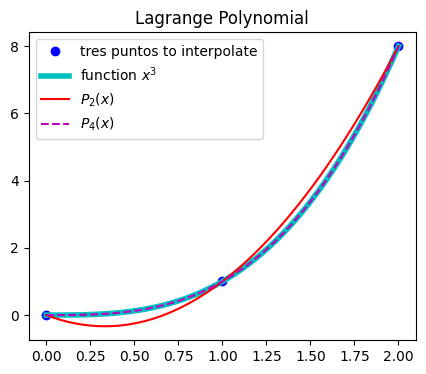

In [ ]:
plt.figure( figsize=(5,4) )
plt.plot(Xn,Yn,'bo',label='tres puntos to interpolate')
plt.plot(x,y,'c-',lw=4,label='function $x^3$')

plt.plot(x, Polynomial(poly.coef[::-1])(x), 'r-', label=r'$P_2(x)$')
plt.plot(x, Polynomial(poly2.coef[::-1])(x), 'm--',label=r'$P_4(x)$')

#plt.plot(x,x*(-2+3*x),'r.', label='polynomio x(-2+3x)')

plt.legend()
plt.legend()
plt.title('Lagrange Polynomial')
plt.show()

In [ ]:
print(Polynomial(poly).coef)
print(Polynomial(poly2).coef)

[ 3. -2.  0.]
[-8.88178420e-16  1.00000000e+00 -1.77635684e-15  0.00000000e+00
  0.00000000e+00]


### <font color='red'>     **Activity: Lagrange Interpolation** </font>

  Write your own implementation of the Lagrange interpolation algorithm during classtime.

  Help: import sympy as sp, and use the variable x = sp.Symbol('x')


In [ ]:
import sympy as sp
#x symbol
x = sp.Symbol('x')
#Arrays
Xn = np.array([0,1,2])
Yn = Xn**3

In [ ]:
#Define Ln,i(x) polynomical
def Lni(Xn,i):
  #ini variables
  num, den, k = 1, 1, 0

  for j in range(len(Xn)):
    if j != i:
      num *= (x-Xn[j])
      den *= (Xn[i]-Xn[j])
  return(num/den)

#Lagrange polynomio
def Pn(Xn,Yn):
  k = 0
  for i in range(len(Xn)):
    k = Yn[i]*Lni(Xn,i) + k
  return(sp.simplify(k))

- - -
## Steps LP

Once defined the formal procedure for constructing a Lagrange Polynomial, we proceed to describe the explicit algorithm:

1. Give the working dataset $(x_i, y_i)$ and stablish how many points you have.
2. Define the functions $L_{n,i}(x)$ in a general way.
3. Add each of those terms as shown in last expression.
4. Evaluate your result wherever you want.

- - -

## Activity LP

<div style="float: right;" markdown="1">
    <img src="http://universe-review.ca/I05-28-NGC7331.jpg">
</div>

One of the very first evidences of the existence of dark matter was the flat rotation curves of spiral galaxies. If we assume the total budget of mass of a galaxy is entirely made of luminous matter, the orbital circular velocity of stars around the galaxy plane should decay according to a keplerian potential. However this is not the case and the circular velocity barely decreases at larger radius, thus indicating the presence of a new non-visible matter component (dark matter). When it is necessary to determine how massive is the dark matter halo embedding a galaxy, an integration of the circular velocity is required. Nevertheless, due to the finite array of a CCD camera, only a discrete set of velocities can be measured and interpolation techniques are required.

## <font color='red'>     **Activity** </font>

In this activity we will take a discrete dataset of the circular velocity as a function of the radius for the galaxy [NGC 7331](http://es.wikipedia.org/wiki/NGC_7331) and perform both, a linear and a Lagrange interpolation. You can download the dataset from this [link](https://raw.githubusercontent.com/sbustamante/ComputationalMethods/master/data/NGC7331.dat).

- - -

- - -

# Divided Differences

In spite of the good precision achieved by the Lagrange interpolating polynomials, analytical manipulation of such an expressions is rather complicated. Furthermore, when applying other polynomials-based techniques like Hermite polynomials, the algorithms present very different ways to achieve the final interpolation, making a comparison unclear.

Divided differences is a way to standardize the notation for interpolating polynomials. Suppose a polynomial $P_n(x)$ and write it in the next form:

$$P_n(x) = a_0 + a_1(x-x_0)+ a_2 (x-x_0)(x-x_1)+\cdots + a_n(x-x_0)\cdots (x-x_{n-1})$$

where $a_i$ are a set of constants to be determined from the given data $(x_i, y_i)$.

Note that due to the definition of an interpolant function, previous expression should satisfy:

$$P_n(x_0) = a_0 = y_0$$

$$P_n(x_1) = a_0 + a_1(x_1-x_0) = y_0 + a_1(x_1-x_0) = y_1 \ \ \ \longrightarrow \ \ \ \ a_1 = \frac{f(x_1)-f(x_0)}{x_1-x_0}$$

$\cdots$ and so.

Defining the **zeroth divided difference** of $x_i$ like

$$D_0[x_i] = f[x_i] = f(x_i) = y_i$$

the **firts divided difference** of $x_i$ like

$$D_1[x_i] = f[x_i, x_{i+1}] = \frac{f[x_{i+1}]-f[x_i]}{x_{i+1}-x_i}$$

$$D_1[x_i] = \frac{D_{0}[x_{i+1}]-D_{0}[x_{i}]}{x_{i+1}-x_i} $$

successively until the **kth divided difference**

$$D_k[x_i] = f[x_i, x_{i+1},\cdots, x_{i+k-1},x_{i+k}] = \frac{f[x_{i+1},x_{i+2}\cdots, x_{i+k}]-f[x_i, x_{i+1},\cdots, x_{i+k-1}]}{x_{i+k}-x_i}$$

$$D_k[x_i] = \frac{D_{k-1}[x_{i+1}]-D_{k-1}[x_{i}]}{x_{i+k}-x_i}$$

These expressions are the fundamental bricks for any interpolating method.

In [ ]:
#Construction of a kth divided difference (recursive code)
def D( i, k, Xn, Yn ):
    #If k+i>N
    if i+k>=len(Xn):
        return 0
    #Zeroth divided difference
    elif k == 0:
        return Yn[i]
    #If higher divided difference
    else:
        return (D(i+1, k-1, Xn, Yn)-D(i, k-1, Xn, Yn))/(Xn[i+k]-Xn[i])

## Example 2

As an example, Lagrange interpolation can be also derived by using divided differences, which is reached through the next equation:

$$P_n(x) = D_0[x_0] + \sum_{k=1}^n D_k[x_0] (x-x_0) \cdots (x-x_{k-1})$$

Note this expression is by far easier to be manipulated analytically as we can know the coefficients of each order.

 ### <font color='red'>     **Activity: Divided difference** </font>
1.  Using the previous expression and the defined function for divided differences construc the $P_2(x)$ for $f(x)=x^3$, $x ϵ [0,2]$ given the three points $[0,1,2]=[x_0,x_1,x_2]$.
2.  Construc the $P_4(x)$ for $f(x)=x^3$, $x_i = [0,2]$ given the 5 points $[0,0.5,1,1.5,2]$.
3.  Show both methods to calculate Lagrange interpolators are equivalents (opcional)...


Help: for $f(x)=x^3$, $x ϵ [0,2]$ given the three points $[0,1,2]=[x_0,x_1,x_2]$. $f(x_i)=[0,1,8]$, we know that $P_2(x)=3x^2-2x$. Show it!

- - -

# Hermite Interpolation

From calculus we know that Taylor polynomials expand a function at a specific point $x_i$, being both functions (the original one and the Taylor function) exactly equal at any derivative-order at that point. Also, as mentioned before, a Lagrange polynomial, given a set of data points, passes through all those points at the same time. However if those points come from an unknown underlying function $f(x)$, the interpolant polynomial might (surely) differ from the real function at any superior derivative-order. So we have:

- **Taylor polynomials** are exact at any order, but that only remains true at a specific point.

- **Lagrange polynomials** pass through all points of a give dataset, but only at zeroth-order. Derivatives are not longer equal.

Once established these differences, we can introduce Hermite polynomials just as a generalization of both, Taylor and Lagrange polynomials.

At first, Hermite polynomials can be approximated at any desired order at all the points, as long as one has all these information. However, for the sake of simplicity and without loss of generality, we shall assume Hermite polynomials equal to the real function at zeroth and first-derivative order.

Let's suppose a dataset $\{x_i\}_i$ for $i = 0,1,\cdots,n$ with the respective values $\{f(x_i)\}_i$ and $\{f'(x_i)\}_i$. If we assume two different polynomials to fit each set of data, i.e. a polynomial for $\{f(x_i)\}_i$ and another for $\{f'(x_i)\}_i$, we obtain $2n+2$ coefficients, however zeroth-order coefficients can be put together so finally there are $2n+1$ independet coefficients to be determined. In this case, we assign the respective Hermite polynimial as $H_{2n+1}(x)$.

## Derivation in terms of divided differences

Remembering the divided differences expression for a Lagrange polynomial

$$P_n(x) = D_0[x_0] + \sum_{k=1}^n D_k[x_0] (x-x_0) \cdots (x-x_{k-1})$$

and by defining a new sequence $\{z_0, z_1, \cdots, z_{2n+1}\}$ such that

$$z_{2i} = z_{2i+1} = x_i \mbox{ for } i = 0,1,\cdots, n$$

However, divided differences has to be modified in order to include first-order derivatives:

![](https://raw.githubusercontent.com/sbustamante/ComputationalMethods/master/material/figures/table_coefficients.png)

Note that $f[z_0,z_1]$ sould be originally

$$f[z_0,z_1] = \frac{f[z_1]-f[z_0]}{z_1-z_0}$$

but replacing $z_0 = z_1 = x_0$ this would lead an indetermination. In order to solve this issue, this indertemination can be readily approximated to the derivative at $z_0$, so

$$f[z_0,z_1] = f'(x_0)$$

or using the previously defined notation

$$D_1[z_0] = f'(x_0)$$

Generally, for first-order divided differences we will have

$$D_1[z_{2i}] = f'(x_i)$$

$$D_1[z_{2i+1}] = D_1[x_i]$$

Higher order divided differences are calculated as usual.

Finally, the Hermite polynomial is built using the next expression

$$H_{2n+1}(x) = D_0[z_0] + \sum_{k=1}^{2n+1} D_k[z_0] (x-z_0) \cdots (x-z_{k-1})$$


## Example 3

Define a routine to calculate divided differences for Hermite polynomials.

In [ ]:
#Construction of a kth divided difference for Hermite polynomials (recursive code)
def Dh( j, k, Zn, Yn, Ypn ):
    #If k+j>N
    if j+k>=len(Zn):
        return 0
    #Zeroth divided difference
    elif k == 0:
        return Yn[j/2]
    #First order divided difference (even indexes)
    elif k == 1 and j%2 == 0:
        return Ypn[j/2]
    #If higher divided difference
    else:
        return (Dh(j+1, k-1, Zn, Yn, Ypn)-Dh(j, k-1, Zn, Yn, Ypn))/(Zn[j+k]-Zn[j])

### <font color='red'> **Activity: Hermite Polynomial** </font>

<font color='red'>    

Calculate a routine, using the previous program for divided differences, that computes the Hermite polynomial given a dataset.

Generate a set of $N$ points of the function $\sin^2(x)$ between $0$ and $2\pi$, including an array of $x$ positions, $y = f(x)$ and first derivative $y' = f'(x)$.

Show which polynomial gives the best approximation to the real function, Hermite or Lagrange polynomial.

</font>

<font color='white'>
Solution:

nbviewer.ipython.org/github/sbustamante/ComputationalMethods/blob/master/activities/hermite-and-lagrange.ipynb
</font>

- - -